# Introduction
The task of the assignment 4 is **Transfer Learning** using a CNN pretrained on *IMAGENET*.

The suggested architecture is the *VGG16*.

The CNN should be used as fixed **feature extractor** on a new task of your choice containing a number of classes in the range from 2 to 10. 

## Classifier
The features extracted from the "*cut models*" were given in input to a **Logistic Regression** classifier.

In fact, Logistic Regression is one of the basic methods for *classification* in machine learning and is used to explain the relationship between one dependent (*binary*) variable and one, or more, independent variables.

In order to avoid **overfitting**, regularization (*l2*) has been applied.

For evaluating the performance, the *accuracy* of the training and the test set has been measured. For the test set the *confusion matrix* has also been calculated. 

# Dataset
The chosen dataset allows a *binary classification* between **dogs** and **cats**.
This choice was made because IMAGENET allows a breed-level classification of these two animals.

The dataset used, available [here](https://www.floydhub.com/moriano/datasets), contains 2500 images for training and 2501 for testing and is perfectly *balanced*.

The images have dimensions equal to 224x224 (as required by the VGG16 model) and are in RGB format.

To generate the dataset the useful function `image_dataset_from_directory` has been used, directly from [Keras API](https://keras.io/api/preprocessing/image/).

In [113]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

In [114]:
# we can use a Google Drive folder as a "normal" folder
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = '/content/gdrive/My Drive/AML/Assignment_4/'

Mounted at /content/gdrive


In [115]:
# https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# create a data generator and preprocess the input 
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

## Training set

In [116]:
# load and iterate training dataset
training_datagen = datagen.flow_from_directory(directory=root_dir+'training/',
                                               # an RGB image has three channels
                                               color_mode='rgb',
                                               # classification task with two classes (cat and dog)
                                               class_mode='binary',
                                               # size required by the model
                                               target_size=(224, 224), 
                                               # size of the batches
                                               batch_size=64,
                                               shuffle=False,
                                               seed=2020
)

Found 2500 images belonging to 2 classes.


In [117]:
# load training labels
training_datagen_labels = training_datagen.labels
training_datagen_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

## Test set

In [118]:
# load and iterate test dataset
test_datagen = datagen.flow_from_directory(directory=root_dir+'test/',
                                            color_mode='rgb',
                                            class_mode='binary',
                                            target_size=(224, 224), 
                                            batch_size=64,
                                            shuffle=False,
                                            seed=2020)

Found 2501 images belonging to 2 classes.


In [119]:
# load test labels
test_datagen_labels = test_datagen.labels
test_datagen_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

# VGG16 (base)
We can notice how the VGG16 base model has more than 138M of parameters (100M of which on *fc1* layer).

In [120]:
# import VGG16 model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# VGG16 (block5_pool)
As a first experiment, we do not want to load the *final dense layers* of the VGG16 base model.
As a consequence the architecture is much smaller, also in the number of parameters (14.7M vs 138.3M). The number of features is 25088.

In [121]:
# base model cut to block5_pool layer
model_block5 = VGG16(weights='imagenet', include_top=False)
model_block5.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [122]:
# extract and reshape features
def block_features(model, datagen):
  # extract the train/test features
  features = model.predict(datagen)
  
  # print the shape (and the first feature)
  print('shape of features:', features.shape)
  #print('features[1]: ', features[1])
  
  # reshape features from 1x7x7x512 to 1x(7x7x512)
  print('RESHAPE...')
  features = features.reshape(features.shape[0], 
                              features.shape[1]*
                              features.shape[2]*
                              features.shape[3])
  
  # print the "new" shape (and the "new" first feature)
  print('shape of features:', features.shape)
  #print('features[1]: ', features[1])
  
  # check the number of nonzero columns for the first feature
  #print('nonzero columns in features[1]: ', np.count_nonzero(features[1])) 
  
  return(features)

In [123]:
# extract training features from model_block5
training_features = block_features(model_block5, training_datagen)

shape of features: (2500, 7, 7, 512)
RESHAPE...
shape of features: (2500, 25088)


# LogisticRegression (block5_pool)
With respect to the "*block5_pool model*", the accuracy of the test set is particularly good (0.98%).


In [124]:
# https://realpython.com/logistic-regression-python/
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [125]:
# logistic regression classifier
def logistic_model(training_features, training_datagen_labels, 
                   test_datagen, test_datagen_labels, model):
  # define classifier
  lr = LogisticRegression(penalty='l2', # regularization
                          #C=10.0,
                          solver='liblinear', # is a good choice for small datasets 
                          multi_class='ovr', # data is binary
                          random_state=2020 # shuffle the data
                          )
  # classifier fitting
  lr.fit(training_features, training_datagen_labels)

  # matrix of probabilities
  # first column is the probability of the predicted output being zero
  # second column is the probability that the output is one
  print('matrix of probabilities for training istances:\n', lr.predict_proba(training_features))
  print()
  
  # extract test features from VGG16 model
  test_features = block_features(model, test_datagen)

  # matrix of probabilities
  # first column is the probability of the predicted output being zero
  # second column is the probability that the output is one
  print()
  print('matrix of probabilities for testing istances:\n', lr.predict_proba(test_features))

  # ratio of the number of correct predictions to the number of observations for training set
  acc_training = lr.score(training_features, training_datagen_labels)

  # ratio of the number of correct predictions to the number of observations for test set
  acc_test = lr.score(test_features, test_datagen_labels)
  # evaluate the performance of classifier by comparing the actual and predicted outputs
  cm = confusion_matrix(test_datagen_labels, lr.predict(test_features))

  return (acc_training, acc_test, cm)

In [126]:
# compute classification metrics to quantify the logistic regression performance wrt model_block5 features
acc_training_block5, acc_test_block5, cm_block5 = logistic_model(training_features, training_datagen_labels, 
                                                                 test_datagen, test_datagen_labels, model_block5)

matrix of probabilities for training istances:
 [[9.99999995e-01 5.23150673e-09]
 [9.99999999e-01 9.41754155e-10]
 [9.99761652e-01 2.38347773e-04]
 ...
 [8.35240158e-06 9.99991648e-01]
 [5.28045089e-04 9.99471955e-01]
 [8.31988150e-07 9.99999168e-01]]

shape of features: (2501, 7, 7, 512)
RESHAPE...
shape of features: (2501, 25088)

matrix of probabilities for testing istances:
 [[9.99241436e-01 7.58563673e-04]
 [9.99999992e-01 7.68981246e-09]
 [9.99999956e-01 4.43682350e-08]
 ...
 [7.07663179e-05 9.99929234e-01]
 [1.48769885e-14 1.00000000e+00]
 [2.26570991e-05 9.99977343e-01]]


In [127]:
# accuracy of model_block5
print('Accuracy on training set: ', acc_training_block5)
print('Accuracy on test set: ', acc_test_block5)

Accuracy on training set:  1.0
Accuracy on test set:  0.9768092762894842


In [128]:
# aesthetic properties for the confusion matrix 
def plot_properties(ax, cm):
  ax.imshow(cm)
  ax.grid(False)
  ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  ax.set_ylim(1.5, -0.5)
  for i in range(2):
      for j in range(2):
          ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

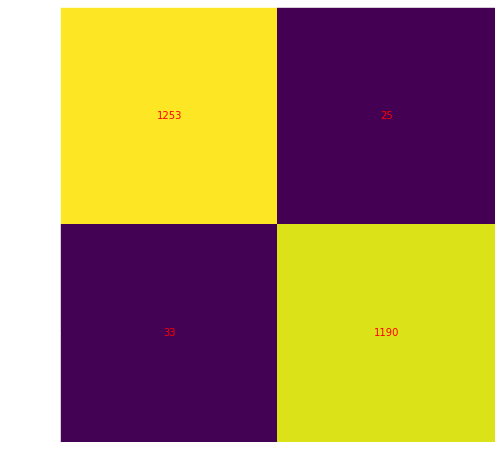

In [129]:
# confusion matrix of model_block5 on test set
fig, ax = plt.subplots(figsize=(8, 8))
plot_properties(ax, cm_block5)
plt.show()

# VGG16 (block4_pool)
In the second experiment conducted, we truncate VGG16 base model after the '*block4_pool*' layer.
Architecture is even smaller and also the number of parameters (7.6M vs 138.3M). The features are 100352.

In [130]:
# base model cut to block4_pool layer
model_block4 = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)
model_block4.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [131]:
# extract training features from model_block4
training_features = block_features(model_block4, training_datagen)

shape of features: (2500, 14, 14, 512)
RESHAPE...
shape of features: (2500, 100352)


# LogisticRegression (block4_pool)
With respect to the "*block4_pool model*", the accuracy of the test set is still good (0.94%).

In [132]:
# compute classification metrics to quantify the logistic regression performance wrt model_block4 features
acc_training_block4, acc_test_block4, cm_block4 = logistic_model(training_features, training_datagen_labels, 
                                                                 test_datagen, test_datagen_labels, model_block4)

matrix of probabilities for training istances:
 [[9.99984769e-01 1.52314551e-05]
 [9.99998689e-01 1.31058176e-06]
 [9.99945987e-01 5.40134031e-05]
 ...
 [1.88283841e-05 9.99981172e-01]
 [1.33604909e-04 9.99866395e-01]
 [1.39420805e-05 9.99986058e-01]]

shape of features: (2501, 14, 14, 512)
RESHAPE...
shape of features: (2501, 100352)

matrix of probabilities for testing istances:
 [[9.69409434e-01 3.05905656e-02]
 [9.99868065e-01 1.31934870e-04]
 [9.99988832e-01 1.11678298e-05]
 ...
 [1.84426797e-04 9.99815573e-01]
 [5.30091357e-07 9.99999470e-01]
 [3.02023536e-05 9.99969798e-01]]


In [133]:
# accuracy of model_block4
print('Accuracy on training set: ', acc_training_block4)
print('Accuracy on test set: ', acc_test_block4)

Accuracy on training set:  1.0
Accuracy on test set:  0.9384246301479409


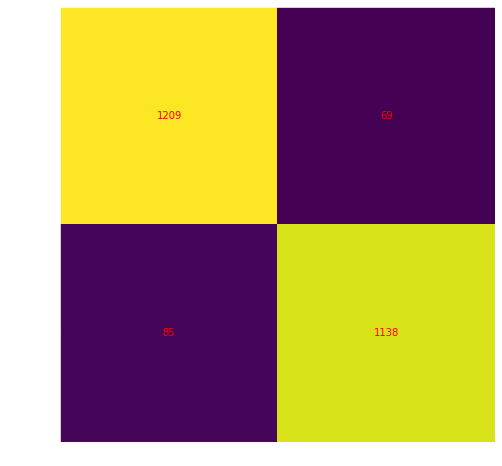

In [134]:
# confusion matrix of model_block4 on test set
fig, ax = plt.subplots(figsize=(8, 8))
plot_properties(ax, cm_block4)
plt.show()

# VGG16 (block3_pool)
Finally, in the last experiment, we cut VGG16 base model after the '*block3_pool*' layer.
The architecture is further smaller, of course also with regard to the parameters (1.7M vs 138.3M). The number of features is even 200704.


In [135]:
# base model cut to block3_pool layer
model_block3 = Model(inputs=base_model.input, outputs=base_model.get_layer('block3_pool').output)
model_block3.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [136]:
# extract training features from model_block3
training_features = block_features(model_block3, training_datagen)

shape of features: (2500, 28, 28, 256)
RESHAPE...
shape of features: (2500, 200704)


# LogisticRegression (block3_pool)
With respect to the "*block3_pool model*", the accuracy of the test set tends to decrease significantly (0.84%).

In [137]:
# compute classification metrics to quantify the logistic regression performance wrt model_block3 features
acc_training_block3, acc_test_block3, cm_block3 = logistic_model(training_features, training_datagen_labels, 
                                                                 test_datagen, test_datagen_labels, model_block3)

matrix of probabilities for training istances:
 [[9.99996725e-01 3.27548846e-06]
 [9.99989220e-01 1.07801715e-05]
 [9.99973683e-01 2.63165792e-05]
 ...
 [2.10825066e-05 9.99978917e-01]
 [6.90724590e-05 9.99930928e-01]
 [2.22372889e-05 9.99977763e-01]]

shape of features: (2501, 28, 28, 256)
RESHAPE...
shape of features: (2501, 200704)

matrix of probabilities for testing istances:
 [[2.33153649e-01 7.66846351e-01]
 [9.89018553e-01 1.09814469e-02]
 [9.99811516e-01 1.88484368e-04]
 ...
 [2.45622631e-02 9.75437737e-01]
 [5.92369827e-08 9.99999941e-01]
 [5.19732340e-02 9.48026766e-01]]


In [138]:
# accuracy of model_block3
print('Accuracy on training set: ', acc_training_block3)
print('Accuracy on test set: ', acc_test_block3)

Accuracy on training set:  1.0
Accuracy on test set:  0.840063974410236


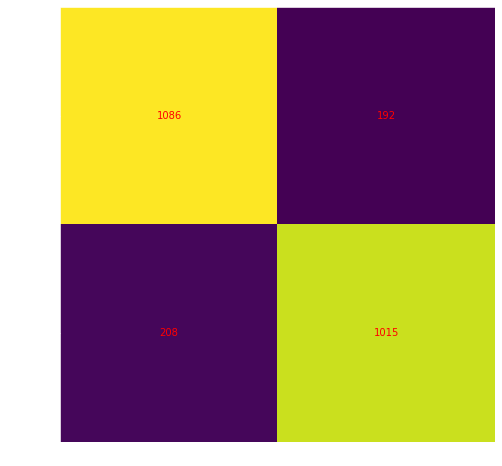

In [139]:
# confusion matrix of model_block3 on test set
fig, ax = plt.subplots(figsize=(8, 8))
plot_properties(ax, cm_block3)
plt.show()

# Conclusions
From the plot that allows us to compare the accuracy with respect to the number of parameters, for training and test set, we can notice that there is *overfitting*. 
In fact, the accuracy for the training set is always equal to 1 (it sounds strange but the *matrix of probabilities* change from one model to another so I think that errors in the code can be excluded).
With regard to the test set, instead, we can see how *accuracy increases with increasing parameters* (which are inversely proportional to the number of features). 
**The best results are then obtained if we cut the model in correspondence of the last layers.** 
A possible explanation is that IMAGENET allows a classification of the classes we consider (that is dogs and cats) and therefore produces good features.

Text(0, 0.5, 'Accuracy')

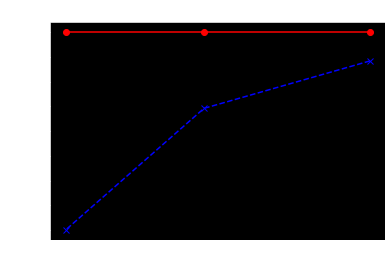

In [140]:
# accuracy comparison between training set and test set wrt the number of parameters
plt.plot([model_block5.count_params(), model_block4.count_params(), model_block3.count_params()],
         [acc_training_block5, acc_training_block4, acc_training_block3],
         '-ro')
plt.plot([model_block5.count_params(), model_block4.count_params(), model_block3.count_params()],
         [acc_test_block5, acc_test_block4, acc_test_block3],
         '--bx')
plt.title("Layers Comparison")
plt.xlabel("# Parameters")
plt.ylabel("Accuracy")